http://rasbt.github.io/biopandas/

In [1]:
import pandas as pd
import numpy as np
from biopandas.pdb import PandasPdb
import pickle
import requests
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
plt.style.use('seaborn-whitegrid')

# Method design

In [2]:
ppdb = PandasPdb().fetch_pdb('5fo8')
df_atoms = ppdb.df['ATOM']
df_atoms.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,SER,,A,23,,...,15.573,-8.829,8.008,1.0,86.75,,,N,NaN,1212
1,ATOM,2,,CA,,SER,,A,23,,...,16.782,-8.177,7.502,1.0,89.92,,,C,NaN,1214
2,ATOM,3,,C,,SER,,A,23,,...,16.675,-6.679,7.165,1.0,90.30,,,C,NaN,1216
3,ATOM,4,,O,,SER,,A,23,,...,17.696,-5.991,7.146,1.0,91.65,,,O,NaN,1218
4,ATOM,5,,CB,,SER,,A,23,,...,17.374,-8.952,6.320,1.0,91.72,,,C,NaN,1220


In [10]:
# Atoms to amino acids
df_structure = ppdb.amino3to1()
idxs = df_structure.index.values
coords = []
for start, stop in zip(idxs[:-1], idxs[1:]):
    coords.append(list(df_atoms[['x_coord', 'y_coord', 'z_coord']].iloc[start:stop].mean(0)))
coords.append(list(df_atoms[['x_coord', 'y_coord', 'z_coord']].iloc[stop:].mean(0)))
coords = np.array(coords).T
df_structure['x'], df_structure['y'], df_structure['z'] = coords[0], coords[1], coords[2]
df_structure.reset_index(inplace=True)
df_structure.head()

,index,chain_id,residue_name,x,y,z
0,0,A,S,17.080333,-8.079500,7.149833
1,6,A,P,14.797286,-5.182857,7.017286
2,13,A,M,17.781125,-1.328250,9.792750
3,21,A,Y,12.844000,-0.712583,9.540917
4,33,A,S,16.153333,4.367333,10.998333


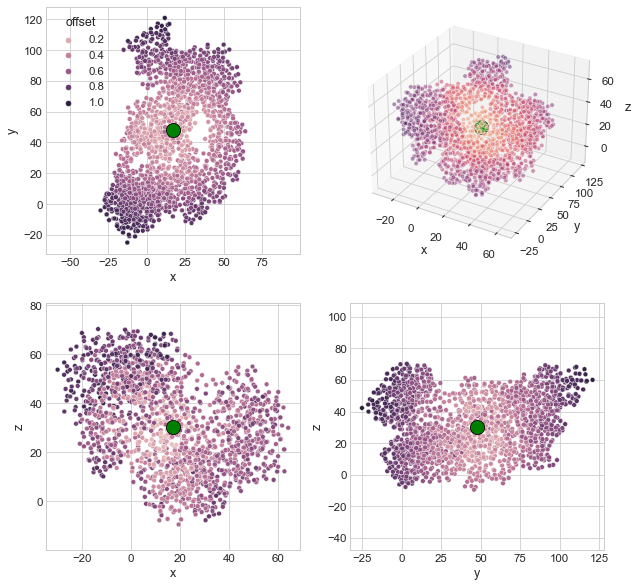

In [15]:
mean_point = df_structure[['x', 'y', 'z']].mean().values
median_point = df_structure[['x', 'y', 'z']].median().values
center_point = ((df_structure[['x', 'y', 'z']].max() + df_structure[['x', 'y', 'z']].min()) / 2).values
offset = np.linalg.norm(df_structure[['x', 'y', 'z']].values - center_point, axis=1)
offset /= offset.max()
df_structure['offset'] = offset

f = plt.figure(figsize=(10, 10))
ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2, projection='3d')
ax3 = f.add_subplot(2, 2, 3)
ax4 = f.add_subplot(2, 2, 4)
ax2.scatter(*coords, alpha=0.5, c=offset, cmap='flare', edgecolors='white', s=20)
# ax.scatter(*mean_point, color='red', s=300)
# ax.scatter(*median_point, color='orange', s=300)
ax2.scatter(*center_point, color='green', edgecolors='black', s=200)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

mapping = {'x':0, 'y':1, 'z':2}
for i, (ax, (x, y)) in enumerate(zip([ax1, ax3, ax4], [('x', 'y'), ('x', 'z'), ('y', 'z')])):        
    legend = 'auto'
    if i > 0:
        legend = False
    sns.scatterplot(data=df_structure, x=x, y=y, hue='offset', legend=legend, ax=ax)
    ax.axis('equal')    
    ax.scatter(center_point[mapping[x]], center_point[mapping[y]], s=200, color='green', edgecolors='black')
plt.savefig('Plots/protein_center.png', dpi=300, bbox_inches='tight')

# Application

In [2]:
def save_protein(uniprot_id, path):
    url = f'https://swissmodel.expasy.org/repository/uniprot/{uniprot_id}.pdb'
    r = requests.get(url, allow_redirects=True)
    with open(f'{path}{uniprot_id}.pdb', 'wb') as f:
        f.write(r.content)

def get_center(coords):
    return (coords.max(0) + coords.min(0)) / 2

def get_protein(code=None, filename=None):
    # Load protein from pdb file
    if code is not None:
        ppdb = PandasPdb().fetch_pdb(code)
    else:
        ppdb = PandasPdb().read_pdb(filename)
    df_atoms = ppdb.df['ATOM']
    df_structure = ppdb.amino3to1()
    # Save chain
    protein = dict()
    protein['chain'] = ''.join(df_structure['residue_name'])
    # Save anino acid coordinates from atom coordinates
    coords = []
    atom_coords = df_atoms[['x_coord', 'y_coord', 'z_coord']].values
    idxs = df_structure.index.values
    for start, stop in zip(idxs[:-1], idxs[1:]):
        coords.append(list(get_center(atom_coords[start:stop])))
    coords.append(list(get_center(atom_coords[stop:])))
    protein['coords'] = np.array(coords)
    # Save the central point and radius of the protein
    protein['center'] = get_center(protein['coords'])
    protein['radius'] = np.linalg.norm(protein['coords'] - protein['center'], axis=1).max()
    return protein
    
def get_offset(peptide, protein):
    indx = protein['chain'].find(peptide)
    if indx == -1:
        return None
    peptide_center = get_center(protein['coords'][indx:indx+len(peptide)])
    offset = np.linalg.norm(peptide_center - protein['center'])
    return offset 

In [4]:
df = pd.read_csv('../Data/reproducibility.csv')
df.head()

,peptide,peptide_aromaticity,peptide_gravy,peptide_helix,peptide_instability_index,peptide_isoelectric_point,peptide_len,peptide_log_len,peptide_log_weight,peptide_mean,...,protein_len,protein_log_len,protein_log_weight,protein_molar_extinction_coefficient,protein_sheet,protein_turn,protein_weight,reproducibility,reproducibility_corrected,peptide_detectability
0,AAAATGTIFTFR,0.166667,0.858333,0.250000,5.300000,9.795020,12,2.484907,7.111823,20.783651,...,356,5.874931,10.599246,25900.0,0.261236,0.233146,40104.5947,0.602647,0.131780,0.791640
1,AAAIQTMSLDAER,0.000000,0.069231,0.153846,43.030769,4.370373,13,2.564949,7.227325,22.568058,...,2124,7.661056,12.374699,336410.0,0.229755,0.266478,236735.5285,0.225532,-0.148407,0.918224
2,AACAQLNDFLQEYGTQGCQV,0.100000,-0.115000,0.250000,33.830000,4.050028,20,2.995732,7.677565,23.491978,...,1564,7.355002,12.056308,171207.5,0.273018,0.243606,172182.0885,0.344353,-0.159834,0.208255
3,AADDTWEPFASGK,0.153846,-0.815385,0.153846,2.676923,4.050028,13,2.564949,7.240249,29.672498,...,820,6.709304,11.417560,142140.0,0.245122,0.215854,90904.0680,0.288063,-0.022109,0.892964
4,AADHDVGSELPPEGVLGALLR,0.000000,0.100000,0.285714,42.357143,4.308305,21,3.044522,7.657439,26.325119,...,37,3.610918,8.346772,5500.0,0.432432,0.135135,4216.5498,0.396802,0.087727,0.731705


In [5]:
# import os
# import pickle

# path = 'Data/Proteins/'
# downloaded = {p.replace('.pdb', '') for p in os.listdir(path)}
# uniprot_ids = list(np.unique(' '.join(list(df.protein_group.values)).replace(';', ' ').split()))
# for uniprot_id in uniprot_ids:
#     if not uniprot_id in downloaded:
#         save_protein(uniprot_id, 'Data/Proteins/')

# files = os.listdir(path)
# proteins = dict()
# for file in files:
#     try:
#         proteins[file.replace('.pdb', '')] = get_protein(filename=path+file)
#     except:
#         print(file)
# pickle.dump(proteins, open('Data/proteins.pkl', 'wb'))

In [6]:
proteins = pickle.load(open('../Data/proteins.pkl', 'rb'))
protein_groups = list(df['protein_id'].values)
protein_groups = list(map(lambda x: x.split(';'), protein_groups))
peptides = list(df.peptide.values)

offsets = []
radius = []
size = []
for peptide, protein_group in zip(peptides, protein_groups):
    offset, r, s = None, None, None
    for protein_id in protein_group:
        if protein_id in proteins:
            offset = get_offset(peptide, proteins[protein_id])
            r = proteins[protein_id]['radius']
            s = len(proteins[protein_id]['chain'])
            if offset is not None:
                break
    offsets.append(offset)
    radius.append(r)
    size.append(s)
df['offset'] = offsets
df['protein_radius'] = radius
df['protein_len'] = size
df['offset_norm'] = df['offset'] / df['protein_radius']
df.dropna(axis=0, inplace=True)
print(df.shape)
df.head()

(1728, 38)


,peptide,peptide_aromaticity,peptide_gravy,peptide_helix,peptide_instability_index,peptide_isoelectric_point,peptide_len,peptide_log_len,peptide_log_weight,peptide_mean,...,protein_molar_extinction_coefficient,protein_sheet,protein_turn,protein_weight,reproducibility,reproducibility_corrected,peptide_detectability,offset,protein_radius,offset_norm
1,AAAIQTMSLDAER,0.000000,0.069231,0.153846,43.030769,4.370373,13,2.564949,7.227325,22.568058,...,336410.0,0.229755,0.266478,236735.5285,0.225532,-0.148407,0.918224,53.169437,96.597452,0.550423
2,AACAQLNDFLQEYGTQGCQV,0.100000,-0.115000,0.250000,33.830000,4.050028,20,2.995732,7.677565,23.491978,...,171207.5,0.273018,0.243606,172182.0885,0.344353,-0.159834,0.208255,67.936748,86.110092,0.788952
3,AADDTWEPFASGK,0.153846,-0.815385,0.153846,2.676923,4.050028,13,2.564949,7.240249,29.672498,...,142140.0,0.245122,0.215854,90904.0680,0.288063,-0.022109,0.892964,26.267934,60.705080,0.432714
5,AAECPAGFVRPPLIIFSVDGFR,0.136364,0.686364,0.363636,57.704545,6.106293,22,3.091042,7.767580,24.880871,...,128027.5,0.196615,0.236979,88505.7857,0.417049,-0.067328,0.691378,22.778712,55.031002,0.413925
6,AAFFLSYEELLQR,0.230769,0.269231,0.461538,53.584615,4.531568,13,2.564949,7.369465,19.567471,...,37422.5,0.212947,0.238501,65836.2134,0.221469,-0.074795,0.849382,11.924096,44.276887,0.269307


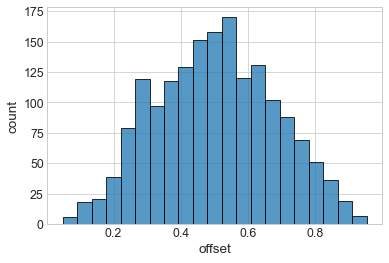

In [29]:
df['offset'] = df['offset_norm']
sns.histplot(data=df, x='offset')
plt.ylabel('count')
plt.savefig('Plots/peptide_offset.png', dpi=300, bbox_inches='tight')

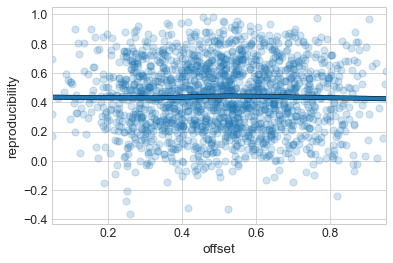

In [27]:
# plt.figure(figsize=(5, 5))
sns.regplot(data=df, x='offset', y='reproducibility', lowess=True, scatter=False, color='black',
            line_kws={'linewidth':5})
sns.regplot(data=df, x='offset', y='reproducibility', lowess=True, color=None,
            scatter_kws={'marker':'o', 's':50, 'alpha':0.2},
            line_kws={'linewidth':4})

plt.savefig('Plots/rep_vs_offset.jpg', dpi=300, bbox_inches='tight')

In [17]:
from sklearn.linear_model import *

def print_coef_intervals(x, y, n, alpha=0.05):
    coefs_boot = []
    coefs = LinearRegression().fit(x, y).coef_
    for i in range(n):
        indxs = np.random.randint(y.size, size=y.size)
        x_boot, y_boot = x[indxs], y[indxs]
        c = LinearRegression().fit(x_boot, y_boot).coef_
        coefs_boot.append(c)
    coefs_boot = np.array(coefs_boot).T
    for i, c in enumerate(coefs_boot):
        c = np.sort(c)
        lower = 2*coefs[i] - c[int((1-alpha/2) * n)]
        upper = 2*coefs[i] - c[int(alpha/2 * n)]
        print(f'[{np.round(lower, 2)}, {np.round(upper, 2)}]')

x = df['offset_norm'].values
y = df['reproducibility'].values
x1 = x.reshape(-1, 1)
features = []
for degree in [1, 2]:
    features.append(x**degree)
x2 = np.vstack(features).T

features = []
for degree in [1, 2, 3]:
    features.append(x**degree)
x3 = np.vstack(features).T

print('1st order:')
print_coef_intervals(x1, y, 1000, alpha=0.05)

print('\n2nd order:')
print_coef_intervals(x2, y, 1000, alpha=0.05)

print('\n3rd order:')
print_coef_intervals(x3, y, 1000, alpha=0.05)

1st order:
[-0.05, 0.07]

2nd order:
[-0.2, 0.42]
[-0.4, 0.2]

3rd order:
[-1.21, 0.61]
[-1.17, 2.78]
[-1.92, 0.71]
